In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

# Хи-квадрат-тест для сравнения выборки с распределением

Дана выборка, либо таблица частот, а также некоторое распределение. Требуется найти вероятность того, что выборка была получена из этого распределения.

Для примера сгенерируем 500 значений из распределения $\sim N(0.2, 0.95)$ и проверим, с какой вероятностью можно отвергнуть гипотезу о том, что эти точки распределены в соответствии со стандартным нормальным распределением $\sim N(0, 1)$.

Будем использовать $n = 500$ элементов выборки, и разбрасывать их по $k = 10$ бинам.

## Выборка

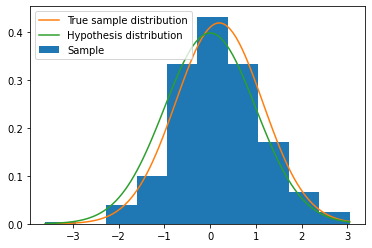

In [2]:
true_dist = stats.norm(loc=0.2, scale=0.95)
n = 500  # sample size
sample = true_dist.rvs(size=n)
test_dist = stats.norm()

k = 10  # number of bins

n_i, bin_edges, _ = plt.hist(sample, bins=k, density=True, label='Sample')
n_i *= n*(bin_edges[1] - bin_edges[0]) # from density values back to counts
pdf_x = np.linspace(sample.min(), sample.max(), 100)
plt.plot(pdf_x, true_dist.pdf(pdf_x), label='True sample distribution')
plt.plot(pdf_x, test_dist.pdf(pdf_x), label='Hypothesis distribution')
plt.legend()


## Тестовая статистика

Введём для $i$-того бина величину $P_i = \int_{x_i}^{x_{i + 1}}f(x) dx$ - вероятность попасть в этот бин случайной величины с теоретическим распределением.

**Эвристика**: для $i$-того бина количество попавших в него элементов выборки задаётся распределением Пуассона с $\lambda = n P_i$. Отсюда следует, что среднее значение этой величины равно $\lambda$, а стандартное отклонение - $\sqrt{\lambda}$.

**Теорема**: величина $\chi^2 \equiv \sum_{i=1}^{k} \left( \frac{n_i - n P_i }{\sqrt{n P_i}} \right)^2$ в пределе при $n \rightarrow \infty$ подчиняется распределению $\chi_r^2$, где $r=k - 1$ степеней свободы.


In [ ]:
def print_sigma_from_chi2_value(chi2_val, k, m):
    chi2_r = stats.chi2(df=k - m - 1)
    p_value = 1 - chi2_r.cdf(chi2_val)
    z = stats.norm.interval(alpha=1 - p_value)[1]
    print(f'significance of rejecting the hypothesis: {z:.2f} sigma ({p_value = :.2e})')

In [3]:
P_i = np.array(
    [test_dist.cdf(x_end) - test_dist.cdf(x_start)
    for x_start, x_end in zip(bin_edges[:-1], bin_edges[1:])]
)

chi2_value = np.sum((n_i - n * P_i)**2 / (n * P_i))
print_sigma_from_chi2_value(chi2_value, k=k, m=0)

significance of rejecting the hypothesis: 3.49 sigma (p_value = 4.85e-04)


## $\chi^2$ как функция параметров и оптимизация

Рассмотрим не фиксированное тестовое распределение, а с варьируемыми $\mu$ и $\sigma$. Тогда получим $\chi^2$ как функцию параметров, минимизируя которую, можно найти их оптимальные значения. После этого для вычисления $p$-value нужно будет использовать распределение $\chi_r^2$ с $r=k - m - 1$ степеней свободы, где $m$ - число варьируемых параметров, в нашем случае $m=2$.

In [4]:
def chi2_dist_fit(theta):
    mu, sigma = theta
    test_dist = stats.norm(loc=mu, scale=sigma)
    P_i = np.array(
        [test_dist.cdf(x_end) - test_dist.cdf(x_start)
        for x_start, x_end in zip(bin_edges[:-1], bin_edges[1:])]
    )
    return np.sum((n_i - n * P_i)**2 / (n * P_i))

In [5]:
from scipy.optimize import minimize

res = minimize(
    chi2_dist_fit,
    np.array([0, 1]),
    method="Nelder-Mead",
)

mu_opt, sigma_opt = res.x
print(f'optimized values: mu = {mu_opt:.3f}, sigma = {sigma_opt:.3f}')
print(f'     true values: mu = {true_dist.mean():.3f}, sigma = {true_dist.std():.3f}')

optimized values: mu = 0.185, sigma = 0.969
     true values: mu = 0.200, sigma = 0.950


In [6]:
print_sigma_from_chi2_value(chi2_val=res.fun, k=k, m=2)

significance of rejecting the hypothesis: 1.80 sigma (p_value = 7.12e-02)


# Хи-квадрат-тест в задаче аппроксимации

В задаче аппроксимации предполагается наличие нескольких точек, в которых известно значение измеряемой величины. Ошибка этого измерения предполагается нормально распределённой. Обозначим среднее измеренное значение $\mu_i$, ошибку - $\sigma_i$.

Пусть существует модель, предсказывающая значения $y_i$ в тех же точках.

Тогда статистика

$$
\chi^2 = \sum_{i=1}^{k} \Big ( \frac{\mu_i - y_i}{\sigma_i} \Big )^2
$$

имеет распределение $\chi_r^2$ с $r=k - m - 1$ степеней свободы, где $m$ - число оптимизируемых параметров.


**Этот метод и был использован в анализе Владимира Игоревича!**

Фрагмент [`gchi2test_sh_var.f`](./gchi2test_sh_var.f):

```fortran
feer(j) = 0.5*(fererl(i)+fereru(i))

...
chi2 = 0.0
do i=1,j
  fmco(i) = fmodee(i)*co
  chi2 = chi2 + ((fmco(i) - fe(i))/feer(i))**2
enddo
```

In [7]:
from matplotlib import gridspec

from modules.data_point import DataSet, NormalDataPoint
from typing import Callable, Optional

In [8]:
def plot_curve_fitting(dataset: DataSet, predict_fn: Optional[Callable[[float], float]] = None):

    PREDICT_COLOR = 'k'

    fig = plt.figure(constrained_layout=True, figsize=(8, 6))
    gs = gridspec.GridSpec(ncols=2, nrows=dataset.size, figure=fig, width_ratios=[0.8, 0.2])
    ax1 = fig.add_subplot(gs[:, 0])

    dataset.plot_points(ax1)

    toy_x = np.linspace(*dataset.x_bounds, 100)
    if predict_fn is not None:
        ax1.plot(toy_x, predict_fn(toy_x), color=PREDICT_COLOR)
        ax1.plot(dataset.x, predict_fn(np.array(dataset.x)), color=PREDICT_COLOR, marker='x', linestyle='none')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    ax_to_share_x = None
    for i in range(dataset.size):
        ax_sm = fig.add_subplot(gs[i, 1], sharex=ax_to_share_x)
        ax_to_share_x = ax_sm if ax_to_share_x is None else ax_to_share_x

        dataset.plot_point_pdf(ax_sm, i)
        if predict_fn is not None:
            ax_sm.axvline(predict_fn(dataset.x[i]), color=PREDICT_COLOR)

        ax_sm.set_ylim(bottom=0)
        ax_sm.set_yticks([])
        ax_sm.set_xticks([])

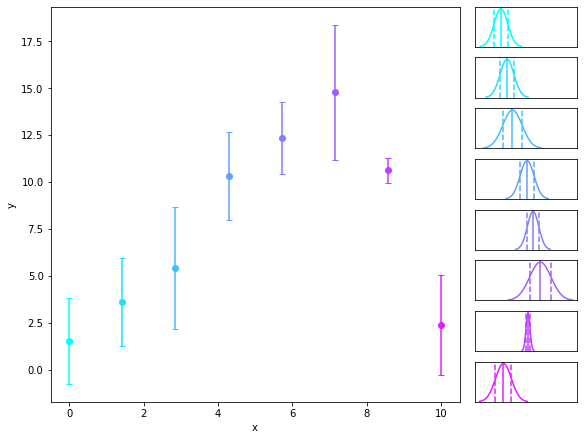

In [9]:
from numpy.polynomial import Polynomial

true_params = [0, 0, 1, -0.1]

xs = np.linspace(0, 10, 8)
sigmas = np.abs(np.random.normal(size=xs.size, loc=2, scale=0.8))
mus = np.array([np.random.normal(loc=mu, scale=sigma) for mu, sigma in zip(Polynomial(true_params)(xs), sigmas)])

normal_dataset = DataSet(
    [NormalDataPoint(x, mu, sigma) for x, mu, sigma in zip(xs, mus, sigmas)]
)

plot_curve_fitting(normal_dataset)


In [10]:
def get_chi2_approx(dataset: DataSet):
    mus = np.array([pt.mean for pt in dataset.points])
    sigmas = np.array([pt.std for pt in dataset.points])

    def chi2_approx(theta):
        test_fn = Polynomial(list(theta))
        y = test_fn(np.array(dataset.x))
        return np.sum(((y - mus) / sigmas)**2)
    
    return chi2_approx

significance of rejecting the hypothesis: 0.06 sigma (p_value = 9.49e-01)


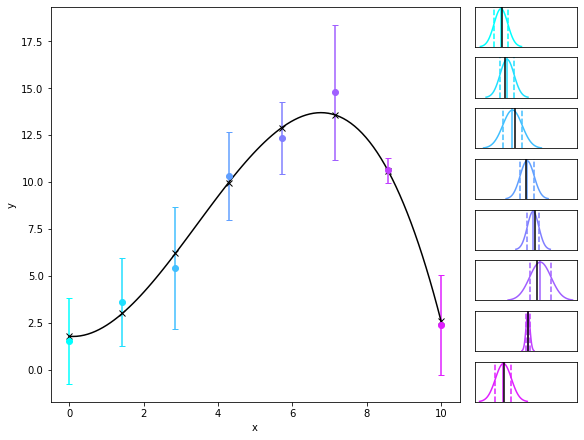

In [11]:
cubic_fit_res = minimize(get_chi2_approx(normal_dataset), np.array([0, 0, 1, -0.1]))

plot_curve_fitting(normal_dataset, Polynomial(cubic_fit_res.x))

print_sigma_from_chi2_value(cubic_fit_res.fun, k=normal_dataset.size, m=4)

significance of rejecting the hypothesis: 1.34 sigma (p_value = 1.80e-01)


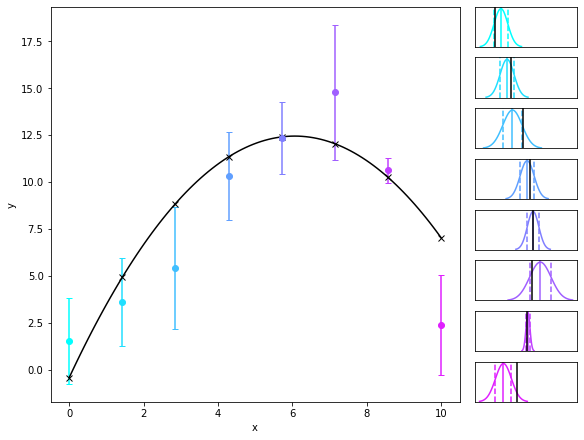

In [12]:
res = minimize(get_chi2_approx(normal_dataset), np.array([15, 0, -1]))

plot_curve_fitting(normal_dataset, Polynomial(res.x))

print_sigma_from_chi2_value(res.fun, k=normal_dataset.size, m=3)

significance of rejecting the hypothesis: 4.12 sigma (p_value = 3.73e-05)


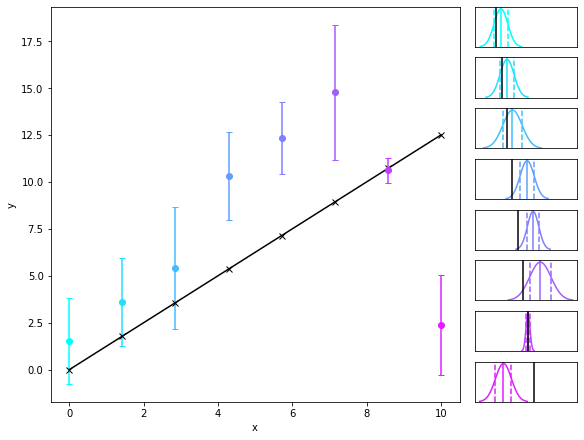

In [13]:
chi2_full = get_chi2_approx(normal_dataset)

def chi2_k_only(k):
    k = k[0]
    return chi2_full(np.array([0, k]))

res = minimize(chi2_k_only, np.array(2))

plot_curve_fitting(normal_dataset, Polynomial([0] + list(res.x)))

print_sigma_from_chi2_value(res.fun, k=normal_dataset.size, m=1)

# Общий метод максимального правдоподобия

Пусть теперь распределения ошибок в точках отличаются от нормального.

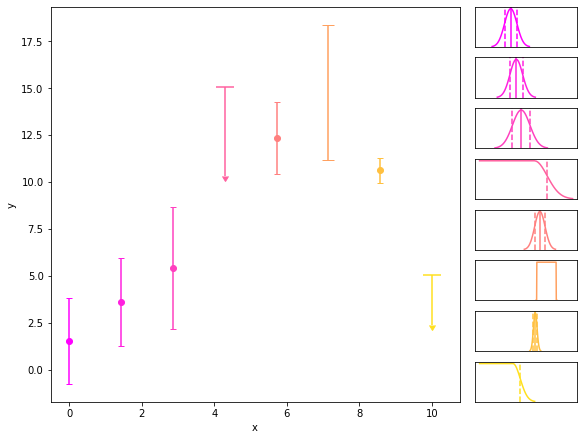

In [14]:
from modules.data_point import UpperLimitDataPoint, UniformDataPoint

pts = normal_dataset.points.copy()
pts[3] = UpperLimitDataPoint(pts[3].x, pts[3].mu, 2*pts[3].sigma)
pts[7] = UpperLimitDataPoint(pts[7].x, pts[7].mu, 1*pts[7].sigma)
pts[5] = UniformDataPoint(pts[5].x, pts[5].mu, pts[5].sigma)

var_dataset = DataSet(pts, cmap='spring')

plot_curve_fitting(var_dataset)

Тогда можно ввести функцию правдоподобия, при фиксированных $y_i$ (предсказаниях модели) равную полной вероятности того, что $y_i$ являются реализацией $i$-того значения.

$$
\mathcal{L} = \prod_{i=1}^{k} P^{(i)}(y_i)
$$

$$
\log \mathcal{L} = \sum_{i=1}^{k} \log P^{(i)}(y_i)
$$

Если $\forall i \; P^{(i)}$ - нормальная плотность распределения, получаем $\log \mathcal{L} = \sum_{i=1}^{k} - \Big ( \frac{\mu_i - y_i}{\sigma_i} \Big )^2 + C$ - с точностью до аддитивной константы это тестовая статистика $\chi^2$ с обратным знаком. В общем случае из $\log \mathcal{L}$ нельзя получить $p$-значения, так как неизвестно распределение. Здесь приходится использовать AIC или подобные критерии.

In [15]:
def get_neg_loglike(dataset: DataSet):

    def negloglike(theta):
        test_fn = Polynomial(list(theta))
        y = test_fn(np.array(dataset.x))

        return - np.sum(
            np.array(
                [pt.logpdf(np.array(y_i)) for pt, y_i in zip(dataset.points, y)]
            )
        )
    
    return negloglike

/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/modules/data_point.py:123: RuntimeWarning: divide by zero encountered in log
  return np.log((np.abs(x - self.mid) < self.hw) / (2 * self.hw))
/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/kbhmenv/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/modules/data_point.py:123: RuntimeWarning: divide by zero encountered in log
  return np.log((np.abs(x - self.mid) < self.hw) / (2 * self.hw))


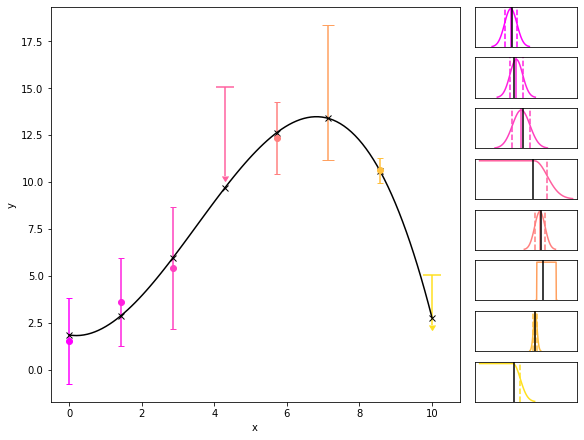

In [16]:
res = minimize(get_neg_loglike(var_dataset), np.array([0, 0, 1, -0.1]))

plot_curve_fitting(var_dataset, Polynomial(res.x))